In [59]:
import numpy as np
import math
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
class BernoulliGreedy:
    def __init__(self, n, alpha=1, beta=1):
        self.n = n
        self.alphas = np.ones(n) * alpha
        self.betas = np.ones(n) * beta
        self.thetas = np.zeros(n)
        self.t = 0
        for i in range(n):
            self.thetas[i] = self.alphas[i] / (self.alphas[i] + self.betas[i])

    def sample(self):
        self.t += 1
        if self.t <= self.n:
            return self.t - 1
        return np.argmax(self.thetas)
    
    def update(self, arm, reward):
        self.alphas[arm] = self.alphas[arm] + reward
        self.betas[arm] = self.betas[arm] + 1 - reward
        self.thetas[arm] = self.alphas[arm] / (self.alphas[arm] + self.betas[arm])

    def run(self, num_rounds, reward_function):
        for t in range(num_rounds):
            arm = self.sample()
            reward = reward_function(arm)
            self.update(arm, reward)
        return np.argmax(self.thetas)

In [3]:
class BernoulliTS:
    def __init__(self, n, prior_alpha=1, prior_beta=1):
        self.n = n
        self.alphas = np.ones(n) * prior_alpha
        self.betas = np.ones(n) * prior_beta
        
    def sample(self):
        theta = np.random.beta(self.alphas, self.betas)
        return np.argmax(theta)
        
    def update(self, arm, reward):
        self.alphas[arm] = self.alphas[arm] + reward
        self.betas[arm] = self.betas[arm] + 1 - reward
        
    def run(self, num_rounds, reward_function):
        for t in range(num_rounds):
            arm = self.sample()
            reward = reward_function(arm)
            self.update(arm, reward)
        return np.argmax(self.alphas / (self.alphas + self.betas))


# Testing Bernoulli Bandit

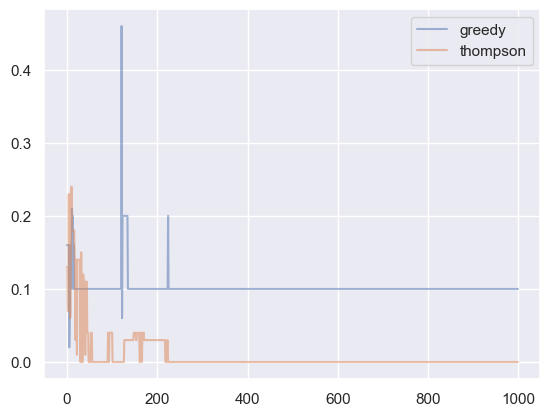

In [5]:
np.random.seed(1337)

def test_bernoulli_bandit(bandit, T):
    regret = np.zeros(T)
    for t in range(T):
        arm = bandit.run(10, lambda arm: np.random.binomial(1, thetas[arm]))
        regret[t] += thetas.max() - thetas[arm]
    return regret

T = 1000
thetas = np.array([x/100 for x in range(1, 50)])
np.random.shuffle(thetas)
bandit_greedy = BernoulliGreedy(49, 1, 1)
bandit_thompson = BernoulliTS(49, 1, 1)
regret_greedy = test_bernoulli_bandit(bandit_greedy, T)
regret_thompson = test_bernoulli_bandit(bandit_thompson, T)
plt.plot(regret_greedy, label='greedy', alpha=0.5)
plt.plot(regret_thompson, label='thompson', alpha=0.5)
plt.legend()
plt.show()


In [6]:
class GaussianGreedy:
    def __init__(self, n, mean=0, std=1):
        self.n = n
        self.prior_mean = mean
        self.prior_std = std
        self.means = np.zeros(n) + mean
        self.stds = np.zeros(n) + std
        self.counts = []
        self.t = 0
        for i in range(n):
            self.counts.append(np.array([]))
        
    def sample(self):
        self.t += 1
        if self.t <= self.n:
            return self.t - 1
        return np.argmax(self.means)
        
    def update(self, arm, reward):
        self.counts[arm] = np.append(self.counts[arm], reward)
        n = self.counts[arm].shape[0]
        self.stds[arm] = 1 / np.sqrt(1 / self.prior_std**2 + n)
        self.means[arm] = self.stds[arm]**2 * np.sum(self.counts[arm])
        
    def run(self, num_rounds, reward_function):
        for t in range(num_rounds):
            arm = self.sample()
            reward = reward_function(arm)
            self.update(arm, reward)
        return np.argmax(self.means)


In [7]:
class GaussianTS:
    def __init__(self, n, mean=0, std=100):
        self.n = n
        self.prior_mean = mean
        self.prior_std = std
        self.means = np.zeros(n) + mean
        self.stds = np.zeros(n) + std
        self.counts = []
        for i in range(n):
            self.counts.append(np.array([]))
        
    def sample(self):
        theta = np.random.normal(self.means, self.stds)
        return np.argmax(theta)
        
    def update(self, arm, reward):
        self.counts[arm] = np.append(self.counts[arm], reward)
        n = self.counts[arm].shape[0]
        self.stds[arm] = 1 / np.sqrt(1 / self.prior_std**2 + n)
        self.means[arm] = self.stds[arm]**2 * np.sum(self.counts[arm])
        
    def run(self, num_rounds, reward_function):
        for t in range(num_rounds):
            arm = self.sample()
            reward = reward_function(arm)
            self.update(arm, reward)
        return np.argmax(self.means)


# Testing Gaussian Bandits

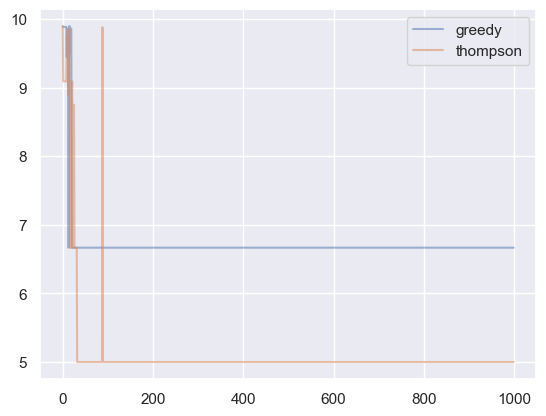

In [8]:
np.random.seed(1337)

def test_gaussian_bandit(bandit, T):
    regret = np.zeros(T)
    for t in range(T):
        arm = bandit.run(10, lambda x: distributions[x].rvs())
        regret[t] = distributions[-1].mean() - distributions[arm].mean()
    return regret

T = 1000
distributions = [norm(10/x, 5) for x in range(100, 0, -1)]

bandit_greedy = GaussianGreedy(99)
bandit_thompson = GaussianTS(99)

regret_greedy = test_gaussian_bandit(bandit_greedy, T)
regret_thompson = test_gaussian_bandit(bandit_thompson, T)

plt.plot(regret_greedy, label='greedy', alpha=0.5)
plt.plot(regret_thompson, label='thompson', alpha=0.5)
plt.legend()
plt.show()


# Example Cascading Recommendations

In [6]:
class CascadingBandit:
    def __init__(self, K, J, thetas):
        self.K = K
        self.J = J
        self.thetas = thetas

    def examine(self, x):
        q = 0
        for j in range(self.J):
            if np.random.uniform() < self.thetas[x[j]]:
                return q
            q += 1

        return math.inf

In [68]:
from itertools import combinations

class CascadeTS:
    def __init__(self, K, J, alpha=1, beta=1):
        self.K = K
        self.J = J
        self.alphas = np.ones(K) * alpha
        self.betas = np.ones(K) * beta

    def h(self, x, thetas):
        return 1 - np.prod([1 - thetas[x[j]] for j in range(self.J)])

    def sample(self):
        thetas = np.random.beta(self.alphas, self.betas)
        comb = combinations(range(self.K), self.J)
        return max(comb, key=lambda x: self.h(x, thetas))
    
    def update(self, x, y):
        for j in range(min(y, self.J)):
            self.alphas[x[j]] += 1 * (j == y)
            self.betas[x[j]] += 1 * (j < y)

    def run(self, num_rounds, bandit):
        for t in range(num_rounds):
            x = self.sample()
            y = bandit.examine(x)
            self.update(x, y)

        return self.sample()

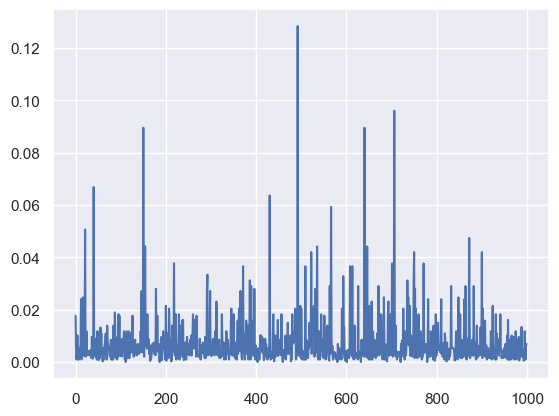

In [78]:
K = 10
J = 5
thetas = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.1])
bandit = CascadingBandit(K, J, thetas)
ts = CascadeTS(K, J)

h_best = ts.h([8, 7, 6, 5, 4], thetas)

np.random.seed(1337)

def test_cascade_bandit(T):
    regret = np.zeros(T)
    for t in range(T):
        x = ts.run(10, bandit)
        regret[t] = h_best - ts.h(x, thetas)
    return regret

T = 1000
regret = test_cascade_bandit(T)
plt.plot(regret)
plt.show()
